In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
import os
import cv2
import random
random.seed(42)
from sklearn.preprocessing import normalize

import pickle

In [2]:
HOME="./Faces_FA_FB/"
fa_H="fa_H"
fa_L="fa_L"
fb_H="fb_H"
fb_L="fb_L"

training_location_H=HOME+"/"+fa_H
testing_location_H=HOME+"/"+fb_H
training_location_L=HOME+"/"+fa_L
testing_location_L=HOME+"/"+fb_L

In [9]:

def get_non50_images_id(location):
    images_name=[]
    for file in os.listdir(location):
        if file.endswith(".pgm"):
            images_name.append(file)

    data_id=np.array([x[:5] for x in images_name])
    to_remove=np.unique(data_id)[:50]
    print(to_remove)
    data_id_final=[i for i in data_id if i not in to_remove]
#     print(len(data_id_final))
    print(len(data_id),len(data_id_final),len(data_id)-len(data_id_final))
    indexes=[i for i, e in enumerate(data_id) if e not in to_remove]
#     print(len(indexes))
    images_name_final=np.array([images_name[i] for i in indexes])
    images_final=np.array([cv2.imread(location+"/"+x) for x in images_name_final])
    return np.array(images_final),np.array(data_id_final)

training_images_H_50,training_data_id_H_50=get_non50_images_id(training_location_H)
print(len(training_images_H_50),len(training_data_id_H_50))
training_images_L_50,training_data_id_L_50=get_non50_images_id(training_location_L)
print(len(training_images_L_50),len(training_data_id_L_50))

(training_data_id_L_50==training_data_id_H_50).all()

['00001' '00002' '00003' '00004' '00005' '00006' '00007' '00008' '00009'
 '00010' '00012' '00013' '00014' '00015' '00016' '00017' '00018' '00019'
 '00020' '00021' '00022' '00023' '00024' '00025' '00026' '00027' '00028'
 '00029' '00030' '00031' '00032' '00033' '00034' '00035' '00036' '00037'
 '00038' '00039' '00040' '00041' '00042' '00070' '00071' '00081' '00083'
 '00093' '00096' '00107' '00108' '00140']
1204 1119 85
1119 1119
['00001' '00002' '00003' '00004' '00005' '00006' '00007' '00008' '00009'
 '00010' '00012' '00013' '00014' '00015' '00016' '00017' '00018' '00019'
 '00020' '00021' '00022' '00023' '00024' '00025' '00026' '00027' '00028'
 '00029' '00030' '00031' '00032' '00033' '00034' '00035' '00036' '00037'
 '00038' '00039' '00040' '00041' '00042' '00070' '00071' '00081' '00083'
 '00093' '00096' '00107' '00108' '00140']
1204 1119 85
1119 1119


True

In [4]:
def show_multiple_images_10(images,title=None):
    rows=int(len(images)/5)
    if rows%1>0:
        rows=rows+1
    columns=5
    fig = plt.figure(figsize=(1.5*columns,1.5*rows))
    if title:
        fig.suptitle(title,fontsize=10)
    
    for i in range(len(images)):
        # Adds a subplot at the 1st position
        fig.add_subplot(rows, columns, i+1)
        # showing image
        plt.imshow(images[i],cmap='gray')
        plt.axis('off')
        plt.savefig("a_I_largest_10.svg",dpi=300,format='svg')


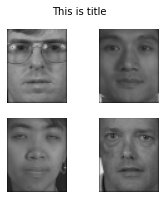

In [5]:
def show_multiple_images(images,title=None):
    rows=int(len(images)/2)
    if rows%1>0:
        rows=rows+1
    columns=2
    fig = plt.figure(figsize=(1.5*columns,1.5*rows))
    if title:
        fig.suptitle(title,fontsize=10)
    
    for i in range(len(images)):
        # Adds a subplot at the 1st position
        fig.add_subplot(rows, columns, i+1)
        # showing image
        plt.imshow(images[i],cmap='gray')
        plt.axis('off')
        
show_multiple_images(training_images_H_50[:4]/255,"This is title")

In [6]:
class MyPCA_train:
    
    def __init__(self,save_name):
        self.save_name=save_name
        
    def find_components(self, input_data):        
        # Standardize data 
        X = input_data.copy()
        self.mean = np.mean(X[:,:,:,0], axis = 0)  
        
        self.image_shape=image_shape=X[0,:,:,0].shape
        eigen_values=[]
        eigen_vectors=[]
        
        data=np.array([(image[:,:,0]-self.mean).flatten() for image in X]).T
        trick_cov_mat = np.matmul(data.T,data)
        
        eig_vals, eig_vecs = np.linalg.eigh(trick_cov_mat) 
        eig_vecs=np.matmul(data,eig_vecs)
        
        eig_vecs=np.array([v/ np.linalg.norm(v) for v in eig_vecs.T])   ## Converting to unit length
        
        eig_pairs=[(np.abs(eig_vals[i]),eig_vecs[i]) for i in range(len(eig_vals))]
        
        eig_pairs.sort(key=lambda x: x[0], reverse=True)
        self.eig_vals_sorted = np.array([x[0] for x in eig_pairs])
        self.eig_vecs_sorted = np.array([x[1] for x in eig_pairs])
                    
        largest_eigenfaces=self.eig_vecs_sorted[:10]
        smallest_eigenfaces=self.eig_vecs_sorted[-10:]
        reshape_to=np.append(10,image_shape)
        return self.mean.reshape(image_shape),largest_eigenfaces.reshape(reshape_to),smallest_eigenfaces.reshape(reshape_to)      
        
    def save_items_transformations(self,input_data):
        X=input_data.copy()
        X=np.array([(image[:,:,0]-self.mean).flatten() for image in X])
        self.projections=np.matmul(X,self.eig_vecs_sorted.T)        
        
    def fit(self,input_data,data_id):
        self.data_id=data_id
        mean,largest_eigenfaces,smallest_eigenfaces=self.find_components(input_data)
        self.save_items_transformations(input_data)
        to_save=[self.projections,self.mean.reshape(self.image_shape),self.eig_vals_sorted,self.eig_vecs_sorted,self.data_id]
        with open(self.save_name,"wb") as filehandler:
            pickle.dump(to_save,filehandler)
        return mean,largest_eigenfaces,smallest_eigenfaces
    
    def getMean(self):
        return self.mean
    
    def getComponents(self):
        return self.components
    
    def getProjections(self):
        return self.projections

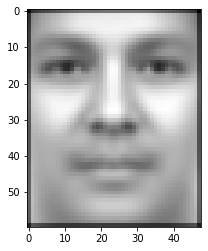

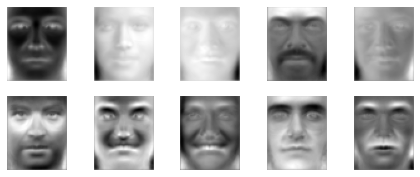

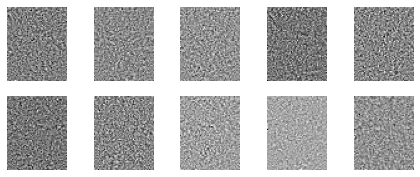

In [7]:
PCA1=MyPCA_train(save_name="High_50_images.pickle")
mean,largest_eigenfaces,smallest_eigenfaces=PCA1.fit(training_images_H_50,training_data_id_H_50)
projections=PCA1.getProjections()
plt.imshow(mean,cmap='gray')
show_multiple_images_10(largest_eigenfaces/255)
show_multiple_images_10(smallest_eigenfaces/255)

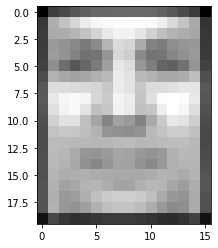

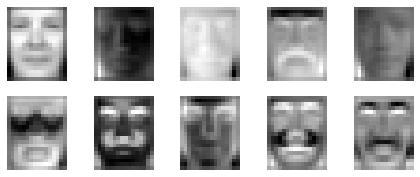

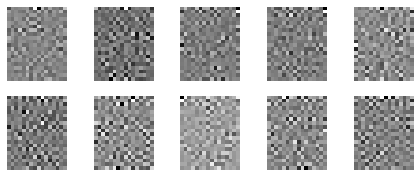

In [8]:
PCA2=MyPCA_train(save_name="Low_50_images.pickle")
mean,largest_eigenfaces,smallest_eigenfaces=PCA2.fit(training_images_L_50,training_data_id_L_50)
projections=PCA2.getProjections()
plt.imshow(mean,cmap='gray')
show_multiple_images_10(largest_eigenfaces/255)
show_multiple_images_10(smallest_eigenfaces/255)